In [1]:
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report


In [2]:
# Install gdown for downloading dataset from Google Drive
!pip install gdown -q

# ✅ Step 1: Download dataset using gdown (Google Drive link)
!gdown --id 1YRDuwJ2LNrWk7IpvVrWYz--VgLVjCmAv -O /content/dataset_blood_group.zip

# ✅ Step 2: Extract the dataset
import zipfile
import os

extract_path = "/content/dataset_blood_group"
with zipfile.ZipFile("/content/dataset_blood_group.zip", 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# ✅ Step 3: Ensure correct dataset folder (handle nested structures)
subfolders = [f for f in os.listdir(extract_path) if os.path.isdir(os.path.join(extract_path, f))]
DATASET_PATH = os.path.join(extract_path, subfolders[0]) if len(subfolders) == 1 else extract_path

# ✅ Step 4: List all class names (blood groups)
blood_groups = [f for f in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, f))]
print("✅ Classes found in dataset:", blood_groups)


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1YRDuwJ2LNrWk7IpvVrWYz--VgLVjCmAv
From (redirected): https://drive.google.com/uc?id=1YRDuwJ2LNrWk7IpvVrWYz--VgLVjCmAv&confirm=t&uuid=e2bf437d-eaa2-487f-96db-ef0ae002eb9b
To: /content/dataset_blood_group.zip
100% 77.8M/77.8M [00:02<00:00, 28.8MB/s]
✅ Classes found in dataset: ['AB-', 'O-', 'O+', 'B-', 'A+', 'A-', 'B+', 'AB+']


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import glob

# ✅ Define dataset path
DATASET_PATH = "/content/dataset_blood_group/dataset"

# ✅ Dictionary to store image counts per blood group
label_counts = {}

# ✅ Loop through each blood group folder
for blood_group in sorted(os.listdir(DATASET_PATH)):  # Sorting ensures order
    blood_group_path = os.path.join(DATASET_PATH, blood_group)

    # ✅ Check if it's a directory (avoid accidental file mismatches)
    if os.path.isdir(blood_group_path):
        # ✅ Find all .BMP images in the folder (case insensitive)
        bmp_files = glob.glob(os.path.join(blood_group_path, "*.BMP")) + \
                    glob.glob(os.path.join(blood_group_path, "*.bmp"))

        # ✅ Store count in dictionary
        label_counts[blood_group] = len(bmp_files)

# ✅ Print counts for each blood group
print("\n📂 Blood Group Image Counts:")
for group, count in label_counts.items():
    print(f"🔹 {group}: {count} images")

# ✅ Print total dataset size
total_images = sum(label_counts.values())
print("\n✅ Total Dataset Size:", total_images, "images")



📂 Blood Group Image Counts:
🔹 A+: 1000 images
🔹 A-: 1000 images
🔹 AB+: 1000 images
🔹 AB-: 1000 images
🔹 B+: 1000 images
🔹 B-: 1000 images
🔹 O+: 1000 images
🔹 O-: 1000 images

✅ Total Dataset Size: 8000 images


📂 First 5 rows of dataset:
                                            Filepath Label
0  /content/dataset_blood_group/dataset/AB+/clust...   AB+
1  /content/dataset_blood_group/dataset/AB+/clust...   AB+
2  /content/dataset_blood_group/dataset/A-/cluste...    A-
3  /content/dataset_blood_group/dataset/AB-/augme...   AB-
4  /content/dataset_blood_group/dataset/B+/cluste...    B+


<ipython-input-6-3f9b1d99e49b>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


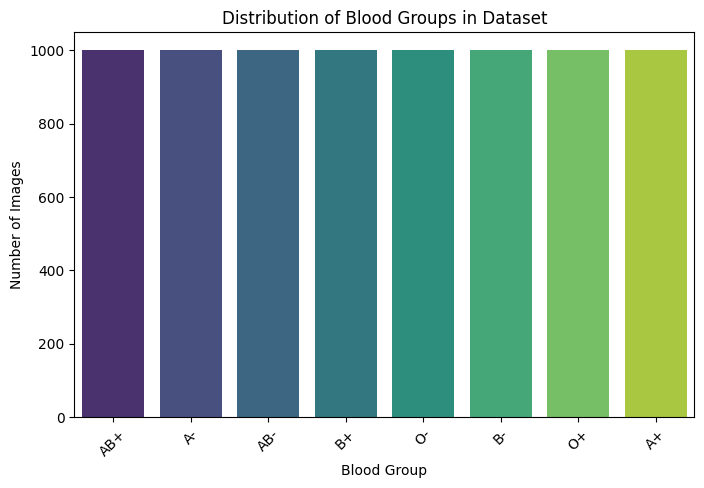


✅ Total dataset size: 8000 images


In [6]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Step 1: Define dataset path
DATASET_PATH = "/content/dataset_blood_group/dataset"

# ✅ Step 2: Collect all image paths & labels
filepaths, labels = [], []

# ✅ Loop through each blood group folder
for blood_group in sorted(os.listdir(DATASET_PATH)):  # Sorting ensures order
    blood_group_path = os.path.join(DATASET_PATH, blood_group)

    # ✅ Check if it's a directory (avoiding any unwanted files)
    if os.path.isdir(blood_group_path):
        # ✅ Find all .BMP images in the folder (case insensitive)
        bmp_files = glob.glob(os.path.join(blood_group_path, "*.BMP")) + \
                    glob.glob(os.path.join(blood_group_path, "*.bmp"))

        # ✅ Store file paths & labels
        filepaths.extend(bmp_files)
        labels.extend([blood_group] * len(bmp_files))  # Assign label for each image

# ✅ Step 3: Create a DataFrame with file paths & labels
data = pd.DataFrame({"Filepath": filepaths, "Label": labels})

# ✅ Step 4: Shuffle dataset to ensure randomness
data = data.sample(frac=1, random_state=42).reset_index(drop=True)  # Added random_state for reproducibility

# ✅ Step 5: Display first 5 rows to check data
print("📂 First 5 rows of dataset:")
print(data.head())

# ✅ Step 6: Count images per blood group
counts = data["Label"].value_counts()

# ✅ Step 7: Visualize the class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=counts.index, y=counts.values, palette="viridis")
plt.xlabel("Blood Group")
plt.ylabel("Number of Images")
plt.title("Distribution of Blood Groups in Dataset")
plt.xticks(rotation=45)
plt.show()

# ✅ Step 8: Print total dataset size
print(f"\n✅ Total dataset size: {len(filepaths)} images")


✅ Training set size: 6400 images
✅ Testing set size: 1600 images


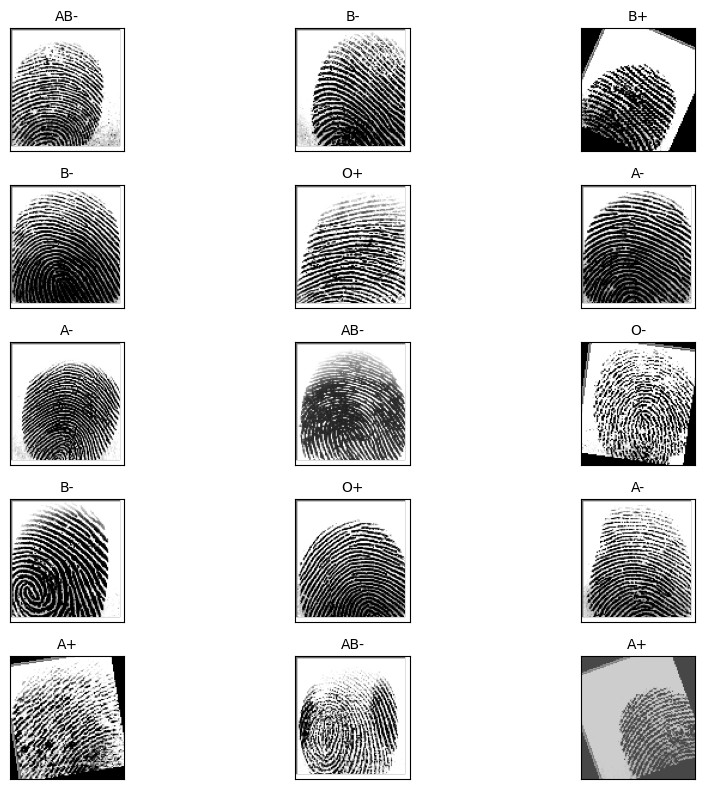


📊 Dataset Summary:
Label
AB+    1000
A-     1000
AB-    1000
B+     1000
O-     1000
B-     1000
O+     1000
A+     1000
Name: count, dtype: int64


In [7]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

# ✅ Step 1: Define dataset path
DATASET_PATH = "/content/dataset_blood_group/dataset"

# ✅ Step 2: Collect image paths & labels
filepaths, labels = [], []

# ✅ Loop through each blood group folder
for blood_group in sorted(os.listdir(DATASET_PATH)):  # Sorting ensures order
    blood_group_path = os.path.join(DATASET_PATH, blood_group)

    # ✅ Ensure it's a valid directory (avoiding unwanted files)
    if os.path.isdir(blood_group_path):
        # ✅ Find all .BMP images in the folder (case insensitive)
        bmp_files = glob.glob(os.path.join(blood_group_path, "*.BMP")) + \
                    glob.glob(os.path.join(blood_group_path, "*.bmp"))

        # ✅ Store file paths & labels
        filepaths.extend(bmp_files)
        labels.extend([blood_group] * len(bmp_files))  # Assign label for each image

# ✅ Step 3: Create a DataFrame with file paths & labels
data = pd.DataFrame({"Filepath": filepaths, "Label": labels}).sample(frac=1, random_state=42).reset_index(drop=True)

# ✅ Step 4: Split dataset into training (80%) and testing (20%) with stratification
train, test = train_test_split(data, test_size=0.20, random_state=42, stratify=data["Label"])

print(f"✅ Training set size: {len(train)} images")
print(f"✅ Testing set size: {len(test)} images")

# ✅ Step 5: Visualize random images from the dataset
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 8), subplot_kw={'xticks': [], 'yticks': []})

# Pick 15 random images (ensuring valid index)
random_samples = data.sample(n=15, random_state=42).reset_index(drop=True)

for i, ax in enumerate(axes.flat):
    if i < len(random_samples):  # Ensure no out-of-bounds errors
        img_path = random_samples.Filepath[i]  # Get file path
        label = random_samples.Label[i]  # Get blood group label

        ax.imshow(plt.imread(img_path))  # Load and display image
        ax.set_title(label, fontsize=10)  # Set title as blood group label

plt.tight_layout()
plt.show()

# ✅ Print dataset stats
print("\n📊 Dataset Summary:")
print(data["Label"].value_counts())


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input  # ✅ Update here

# ✅ Step 1: Define ImageDataGenerator settings
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # ✅ Use MobileNetV2's preprocess function
    validation_split=0.2  # ✅ Keeps 20% of training data for validation
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # ✅ Use MobileNetV2 preprocess function

# ✅ Step 2: Create Training & Validation Generators
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col="Filepath",
    y_col="Label",
    target_size=(224, 224),  # ✅ MobileNetV2 expects 224x224
    batch_size=32,
    class_mode="categorical",
    subset="training",  # ✅ Uses the 80% training split
    shuffle=True,
    seed=42
)

valid_gen = train_datagen.flow_from_dataframe(
    dataframe=train,  # ✅ Keep validation from training set split
    x_col="Filepath",
    y_col="Label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation",  # ✅ Uses the 20% validation split
    shuffle=False,
    seed=42
)

# ✅ Step 3: Create Testing Generator (no augmentation)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col="Filepath",
    y_col="Label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)


Found 5120 validated image filenames belonging to 8 classes.
Found 1280 validated image filenames belonging to 8 classes.
Found 1600 validated image filenames belonging to 8 classes.


In [9]:
from tensorflow.keras.applications import MobileNetV2  # ✅ Use MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ✅ Define the base pre-trained MobileNetV2 model
pretrained_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# ✅ Unfreeze the last 30 layers for fine-tuning
for layer in pretrained_model.layers[-30:]:
    layer.trainable = True

# ✅ Add improved classification layers
x = GlobalAveragePooling2D()(pretrained_model.output)  # ✅ Efficient pooling layer
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(8, activation='softmax')(x)  # ✅ 8 classes for blood group classification

# ✅ Create the model
model = Model(inputs=pretrained_model.input, outputs=outputs)

# ✅ Compile with a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # ✅ Slightly higher than DenseNet for MobileNet
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.000001,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ✅ Train the model
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=40,  # ✅ Increased epochs with early stopping
    callbacks=[early_stopping, reduce_lr]
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 73s 137ms/step - accuracy: 0.2731 - loss: 2.3059 - val_accuracy: 0.2672 - val_loss: 2.1551 - learning_rate: 1.0000e-04
Epoch 2/40
160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.6184 - loss: 1.0399 - val_accuracy: 0.4383 - val_loss: 1.5977 - learning_rate: 1.0000e-04
Epoch 3/40
160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.7493 - loss: 0.6979 - val_accuracy: 0.5164 - val_loss: 1.3132 - learning_rate: 1.0000e-04
Epoch 4/40
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.8159 - loss: 0.5072 - val_accuracy: 0.5781 - val_loss: 1.1533 - learning_rate: 1.0000e-04
Epoch 5/40
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.8441 - loss: 0.4211 - val_accuracy: 0.5234 - val_loss: 1.2891 - learning_rate: 1.0000e-04
Epoch 6/40
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.8641 - loss: 0.3523 - val_accuracy: 0.6281 - val_loss: 1.0390 - learning_rate: 1.0000e-04
Epoch 7/40
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - 

<Figure size 1000x500 with 0 Axes>

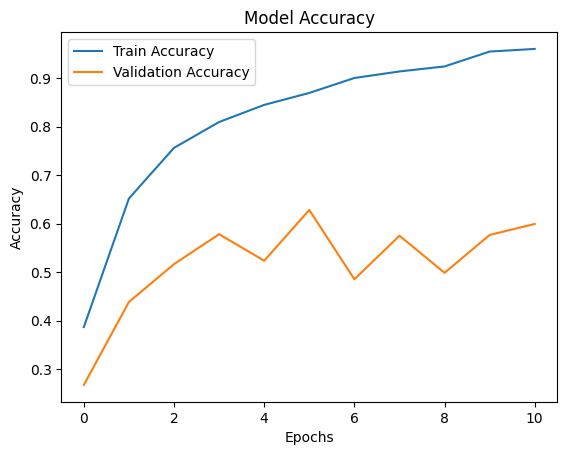

<Figure size 1000x500 with 0 Axes>

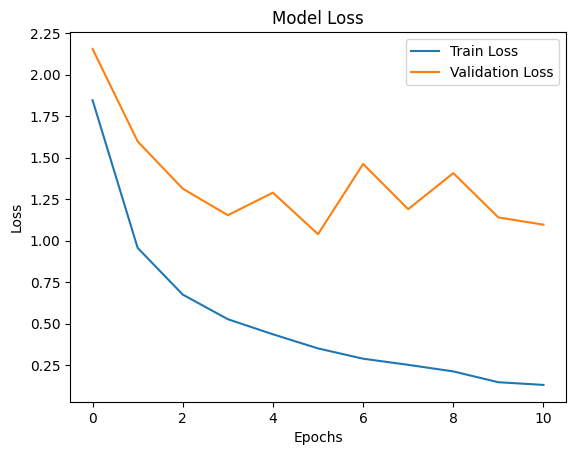

Validation Loss: 1.03899
Validation Accuracy: 62.81%
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step
              precision    recall  f1-score      support
A+             0.687898  0.662577  0.675000   163.000000
A-             0.563107  0.711656  0.628726   163.000000
AB+            0.772152  0.693182  0.730539   176.000000
AB-            0.980392  0.289017  0.446429   173.000000
B+             0.486034  0.612676  0.542056   142.000000
B-             0.658683  0.670732  0.664653   164.000000
O+             0.592814  0.682759  0.634615   145.000000
O-             0.574359  0.727273  0.641834   154.000000
accuracy       0.628125  0.628125  0.628125     0.628125
macro avg      0.664430  0.631234  0.620481  1280.000000
weighted avg   0.672555  0.628125  0.621212  1280.000000


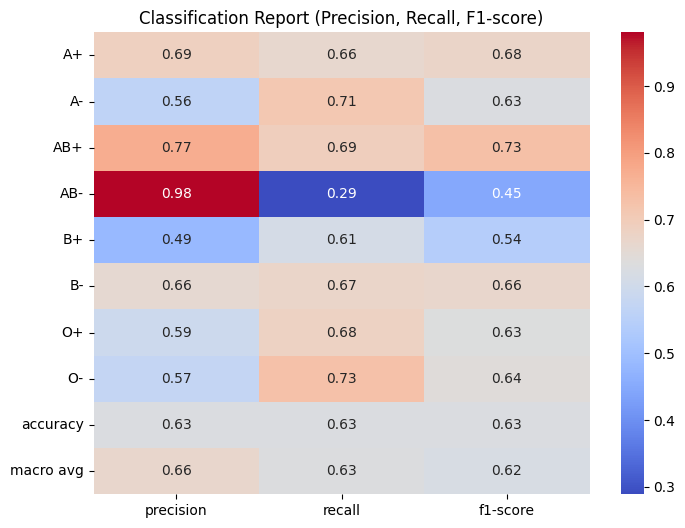

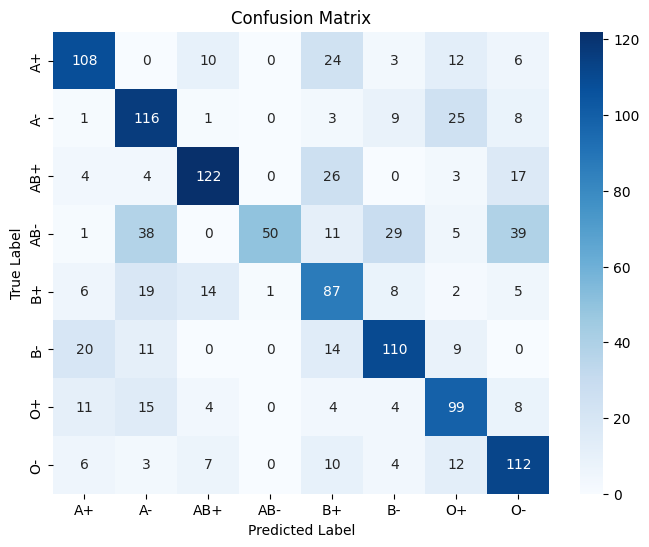

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ✅ Plot training history: Accuracy
plt.figure(figsize=(10, 5))
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.show()

# ✅ Plot training history: Loss
plt.figure(figsize=(10, 5))
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Validation Loss"])
plt.show()

# ✅ Evaluate the model on validation data
results = model.evaluate(valid_gen, verbose=0)
print(f"Validation Loss: {results[0]:.5f}")
print(f"Validation Accuracy: {results[1]*100:.2f}%")

# ✅ Predict labels for validation data
pred_probs = model.predict(valid_gen)
pred_labels = np.argmax(pred_probs, axis=1)  # Convert to class indices

# ✅ Get true labels
true_labels = valid_gen.classes  # True class indices from generator

# ✅ Get class mapping
labels = train_gen.class_indices  # Class names and their index mapping
labels = {v: k for k, v in labels.items()}  # Reverse mapping (index → label)

# ✅ Convert numerical indices to actual class names
pred_labels_text = [labels[i] for i in pred_labels]
true_labels_text = [labels[i] for i in true_labels]

# ✅ Print Full Classification Report
report = classification_report(true_labels_text, pred_labels_text, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

# ✅ Plot Classification Report as a Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Classification Report (Precision, Recall, F1-score)")
plt.show()

# ✅ Confusion Matrix
cm = confusion_matrix(true_labels_text, pred_labels_text, labels=list(labels.values()))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels.values(), yticklabels=labels.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [13]:
model.save("model_blood_group_detection.h5")

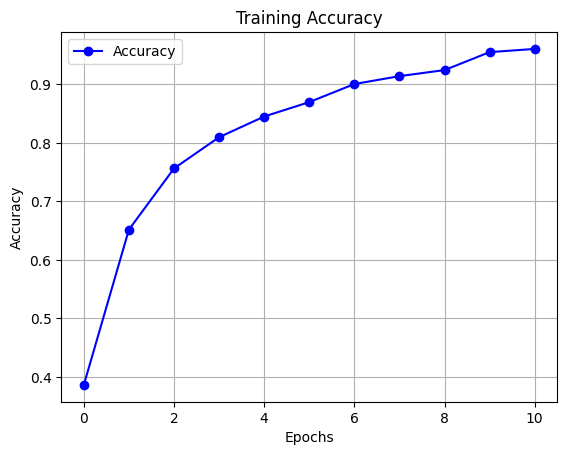

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], marker='o', linestyle='-', color='blue', label='Accuracy')
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()


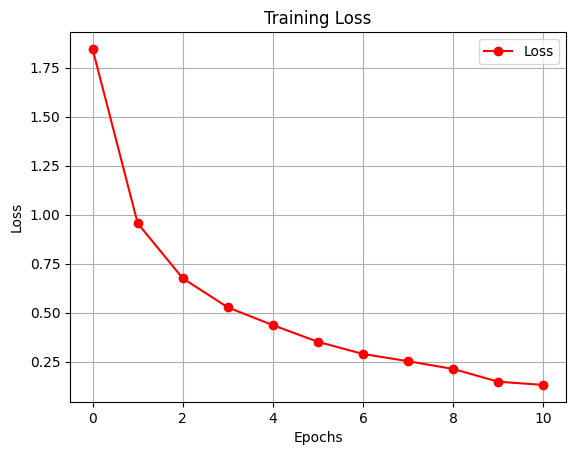

In [15]:
plt.plot(history.history['loss'], marker='o', linestyle='-', color='red', label='Loss')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()


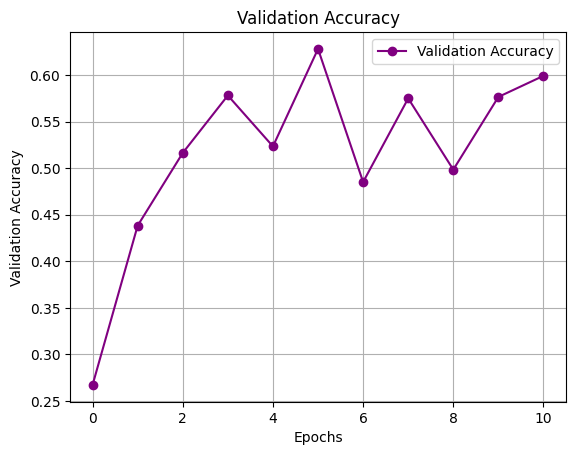

In [16]:
plt.plot(history.history['val_accuracy'], marker='o', linestyle='-', color='purple', label='Validation Accuracy')
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.grid()
plt.legend()
plt.show()


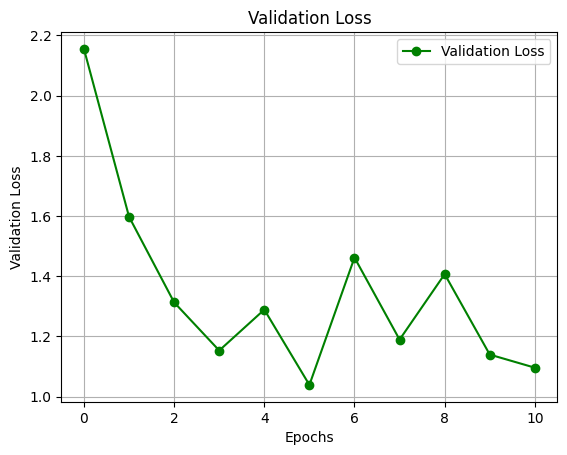

In [17]:
plt.plot(history.history['val_loss'], marker='o', linestyle='-', color='green', label='Validation Loss')
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.grid()
plt.legend()
plt.show()


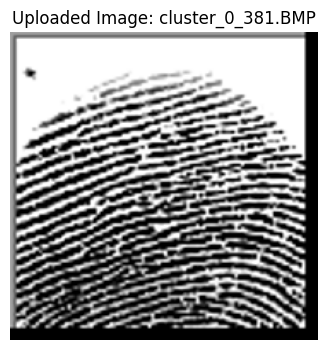

Prediction: A+ - (26.31% Confidence)

🟢 Common (30% of population)
🔄 Can donate to: A+, AB+
🩸 Can receive from: A+, A-, O+, O-
⚠️ Higher risk of heart disease and certain cancers
🛡️ Best bacterial immunity response
🧠 Often analytical and organized
👥 Emma Watson, Rihanna, Tom Cruise
🥗 Mostly plant-based diet with lean protein


Do you want to continue?


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from IPython.display import display, clear_output, HTML
from PIL import Image as PILImage
import io
from google.colab import files

# Load the model
model = load_model("model_blood_group_detection.h5")

# Blood group labels
labels = {0: 'A+', 1: 'A-', 2: 'AB+', 3: 'AB-', 4: 'B+', 5: 'B-', 6: 'O+', 7: 'O-'}

# Enhanced blood group info with more details
blood_group_info = {
    "A+": {
        "Rarity": "🟢 Common (30% of population)",
        "Compatibility": "🔄 Can donate to: A+, AB+",
        "Can Receive From": "🩸 Can receive from: A+, A-, O+, O-",
        "Vulnerability": "⚠️ Higher risk of heart disease and certain cancers",
        "Strengths": "🛡️ Best bacterial immunity response",
        "Personality": "🧠 Often analytical and organized",
        "Famous People": "👥 Emma Watson, Rihanna, Tom Cruise",
        "Diet Recommendation": "🥗 Mostly plant-based diet with lean protein"
    },
    "A-": {
        "Rarity": "🟠 Rare (6% of population)",
        "Compatibility": "🔄 Can donate to: A+, A-, AB+, AB-",
        "Can Receive From": "🩸 Can receive from: A-, O-",
        "Vulnerability": "⚠️ Sensitive to organ transplants and dietary changes",
        "Strengths": "🩸 Best for platelet donations and higher white blood cell count",
        "Personality": "🧠 Detail-oriented and reserved",
        "Famous People": "👥 Marilyn Monroe, Paul McCartney",
        "Diet Recommendation": "🥗 Low-fat diet with high-quality proteins"
    },
    "B+": {
        "Rarity": "🟢 Common (9% of population)",
        "Compatibility": "🔄 Can donate to: B+, AB+",
        "Can Receive From": "🩸 Can receive from: B+, B-, O+, O-",
        "Vulnerability": "⚠️ Higher diabetes risk and autoimmune disorders",
        "Strengths": "🍽️ Flexible digestive system, adaptable metabolism",
        "Personality": "🧠 Creative and independent thinkers",
        "Famous People": "👥 Jackie Chan, Leonardo DiCaprio",
        "Diet Recommendation": "🥗 Balanced diet with diverse food groups"
    },
    "B-": {
        "Rarity": "🔴 Rare (2% of population)",
        "Compatibility": "🔄 Can donate to: B+, B-, AB+, AB-",
        "Can Receive From": "🩸 Can receive from: B-, O-",
        "Vulnerability": "⚠️ Prone to infections and inflammatory conditions",
        "Strengths": "💪 Most resistant to fatigue and stress",
        "Personality": "🧠 Independent and decisive nature",
        "Famous People": "👥 Mila Kunis, Tom Selleck",
        "Diet Recommendation": "🥗 High-protein diet with regular meals"
    },
    "AB+": {
        "Rarity": "🔵 Very Rare (4% of population)",
        "Compatibility": "🌍 Universal plasma donor",
        "Can Receive From": "🩸 Can receive from all blood types (Universal recipient)",
        "Vulnerability": "⚠️ Higher risk of blood clots and cardiovascular issues",
        "Strengths": "🛡️ Strong immune tolerance and adaptation",
        "Personality": "🧠 Versatile and adaptable mindset",
        "Famous People": "👥 John F. Kennedy, Marilyn Manson",
        "Diet Recommendation": "🥗 Mediterranean diet with variety"
    },
    "AB-": {
        "Rarity": "🟣 Extremely Rare (1% of population)",
        "Compatibility": "🌍 Can donate to: AB+, AB-",
        "Can Receive From": "🩸 Can receive from: A-, B-, O-, AB-",
        "Vulnerability": "⚠️ Prone to low iron levels and anemia",
        "Strengths": "🔬 Best in tissue compatibility for transplants",
        "Personality": "🧠 Complex thinkers with dual perspectives",
        "Famous People": "👥 Mark Zuckerberg, Cindy Crawford",
        "Diet Recommendation": "🥗 Iron-rich foods with antioxidants"
    },
    "O+": {
        "Rarity": "🟢 Most Common (37% of population)",
        "Compatibility": "🔄 Can donate to: O+, A+, B+, AB+",
        "Can Receive From": "🩸 Can receive from: O+, O-",
        "Vulnerability": "⚠️ Higher risk of ulcers and digestive disorders",
        "Strengths": "💪 Universal donor and robust immune system",
        "Personality": "🧠 Natural leaders and resilient characters",
        "Famous People": "👥 Queen Elizabeth II, Bill Clinton",
        "Diet Recommendation": "🥗 High-protein, low-carb diet with regular meals"
    },
    "O-": {
        "Rarity": "🔴 Rarest (7% of population)",
        "Compatibility": "🌍 Universal blood donor (can donate to all blood types)",
        "Can Receive From": "🩸 Can receive from: O- only",
        "Vulnerability": "⚠️ Prone to low blood pressure and stress-related issues",
        "Strengths": "🛡️ Best emergency donor, highly valued in medical settings",
        "Personality": "🧠 Intuitive and determined individuals",
        "Famous People": "👥 Charlie Chaplin, Paul Newman",
        "Diet Recommendation": "🥗 Balanced diet rich in iron and vitamins"
    }
}

def handle_yes():
    clear_output()
    predict_blood_group()

def handle_no():
    clear_output()
    display(HTML("<p style='font-weight: bold; font-size: 16px; color: #4CAF50;'>Thank you for using the Blood Group Detection App!</p>"))

# Create button widgets that work in Colab
yes_button = widgets.Button(description="Yes", button_style="success")
no_button = widgets.Button(description="No", button_style="danger")

# Assign button handlers
yes_button.on_click(lambda b: handle_yes())
no_button.on_click(lambda b: handle_no())

# Function to predict blood group from image
def predict_blood_group():
    # Display upload status
    display(HTML("<p style='font-weight: bold; color: #2196F3;'>Uploading image...</p>"))

    # Upload using Colab's file uploader
    uploaded = files.upload()

    if not uploaded:
        display(HTML("<p style='color: red;'>No file was uploaded. Please try again.</p>"))
        predict_blood_group()
        return

    # Get the first file
    file_name = next(iter(uploaded))
    img_bytes = uploaded[file_name]

    # Display processing status
    clear_output()
    display(HTML("<p style='font-weight: bold; color: #2196F3;'>Predicting blood group... Please wait.</p>"))

    # Process image
    img = PILImage.open(io.BytesIO(img_bytes)).convert("RGB").resize((224, 224))


    # Convert to array and preprocess
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Make prediction
    result = model.predict(x)
    predicted_class = np.argmax(result)
    predicted_label = labels[predicted_class]
    confidence = result[0][predicted_class] * 100  # Confidence percentage

    # Clear outputs
    clear_output()

    # Display image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"Uploaded Image: {file_name}")
    plt.axis('off')
    plt.show()

    # Display results with each item on a new line
    print(f"Prediction: {predicted_label} - ({confidence:.2f}% Confidence)\n")

    # Display each piece of info on a new line
    info = blood_group_info[predicted_label]
    for key, value in info.items():
        print(f"{value}")

    # Add spacing before the continue question
    print("\n\nDo you want to continue?")
    display(widgets.HBox([yes_button, no_button]))

# Start the application
predict_blood_group()